In [2]:
!pip install emcee
!pip install corner
import numpy as np
import pandas as pd
import random as rnd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import poisson
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
import emcee
from scipy.optimize import minimize
import math as mth
from scipy.special import gamma
import os

In [6]:
# Leggi il file covid
df = pd.read_csv(r'C:\Users\Matteo\Desktop\Dati1.csv')

# Filtra i dati del FVG
df_fvg = df[df['denominazione_regione'] == 'Friuli Venezia Giulia']

# Salva solo le colonne con data e nuovi positivi 
df_fvg = df_fvg[['data', 'nuovi_positivi']]


# Specifica che la colonna data contiene dati in formato datatime
df_fvg['data'] = pd.to_datetime(df_fvg['data'])

# Verifichiamo di aver preso i dati giusti (Beh... a questo punto si)
print(df_fvg)

                     data  nuovi_positivi
5     2020-02-24 18:00:00               0
26    2020-02-25 18:00:00               0
47    2020-02-26 18:00:00               0
68    2020-02-27 18:00:00               0
89    2020-02-28 18:00:00               0
...                   ...             ...
30686 2024-02-24 17:00:00               4
30707 2024-02-25 17:00:00               1
30728 2024-02-26 17:00:00               4
30749 2024-02-27 17:00:00               3
30770 2024-02-28 17:00:00               5

[1466 rows x 2 columns]


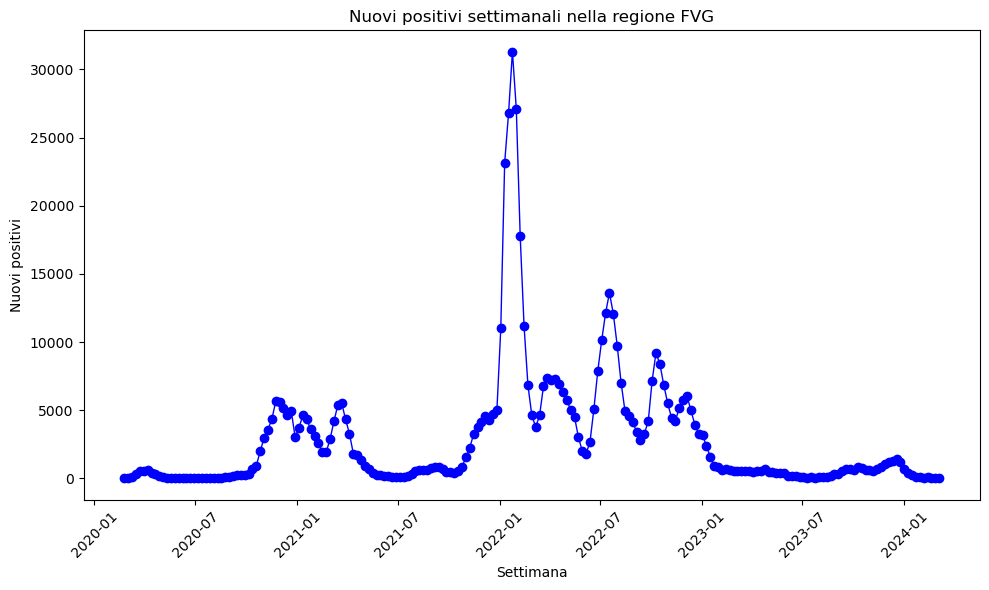

In [4]:
# Raggruppa i dati settimanali e vediamo l'andamento del covid in FVG fino ad oggi
df_weekly = df_fvg.resample('W-Mon', on='data').sum()

# Plotta i dati dell'andamento COVID
plt.figure(figsize=(10, 6))
plt.plot(df_weekly.index, df_weekly['nuovi_positivi'], marker='o', linestyle='-', color='blue', linewidth=1)
plt.title('Nuovi positivi settimanali nella regione FVG')
plt.xlabel('Settimana')
plt.ylabel('Nuovi positivi')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [16]:
#DEFINIZIONE FUNZIONE LOGISTICA E DI GOMPERTZ e NUOVI CONTAGI

#funzione Logistica
def logistica(t, A, k, t0):
    return A / (1 + np.exp(-k * (t - t0)))

def nuovi_contagi_logistica(t, A, k, t0):  
    f_t = logistica(t, A, k, t0)
    f_t1 = logistica(t + 1, A, k, t0)
    differenza = f_t1 - f_t
    return differenza


# Funzione di Gompertz
def gompertz(t, A, k, t0):
    return A * np.exp(-np.log(A) * np.exp(-k * (t - t0)))

def nuovi_contagi_gompertz(t, A, k, t0):
    g_t = gompertz(t, A, k, t0)
    g_t1 = gompertz(t + 1, A, k, t0)
    contagi_g = g_t1 - g_t
    return contagi_g

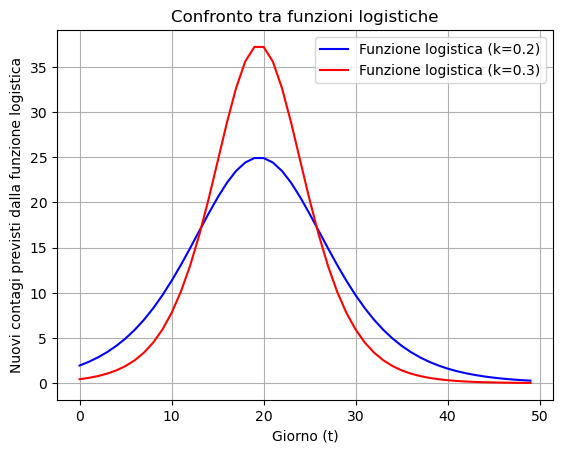

In [23]:
#Plot della funzione logistica, con due ritmi di contagio leggermente diversi e su uno stesso grafico


# Creiamo il dominio della funzione che plotteremo
valori_t = list(range(50))


# Dati iniziali
A = 500
k1 = 0.2
k2 = 0.3
t0 = 20

# Calcola i nuovi contagi per entrambe le funzioni logistiche
logistica_t_1 = [nuovi_contagi_logistica(t, A, k1, t0) for t in valori_t]
logistica_t_2 = [nuovi_contagi_logistica(t, A, k2, t0) for t in valori_t]

# Plottiamo entrambe le funzioni
plt.plot(valori_t, logistica_t_1, label="Funzione logistica (k=0.2)", color="blue")
plt.plot(valori_t, logistica_t_2, label="Funzione logistica (k=0.3)", color="red")

plt.xlabel('Giorno (t)')
plt.ylabel('Nuovi contagi previsti dalla funzione logistica')
plt.title('Confronto tra funzioni logistiche')
plt.grid(True)
plt.legend()
plt.show()

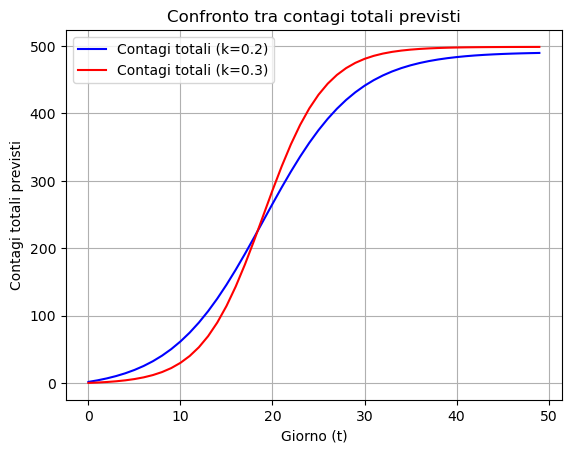

'notiamo che il problema di questa funzione è che non tiene conto di chi potrebbe guarire'

In [25]:
# Calcola i contagiati totali
contagi_totali_1 = np.cumsum(logistica_t_1)
contagi_totali_2 = np.cumsum(logistica_t_2)

# Plottiamo i contagiati totali
plt.plot(valori_t, contagi_totali_1, label="Contagi totali (k=0.2)", color="blue")
plt.plot(valori_t, contagi_totali_2, label="Contagi totali (k=0.3)", color="red")
plt.xlabel('Giorno (t)')
plt.ylabel('Contagi totali previsti')
plt.title('Confronto tra contagi totali previsti')
plt.grid(True)
plt.legend()
plt.show()

'''notiamo che il problema di questa funzione è che non tiene conto di chi potrebbe guarire'''

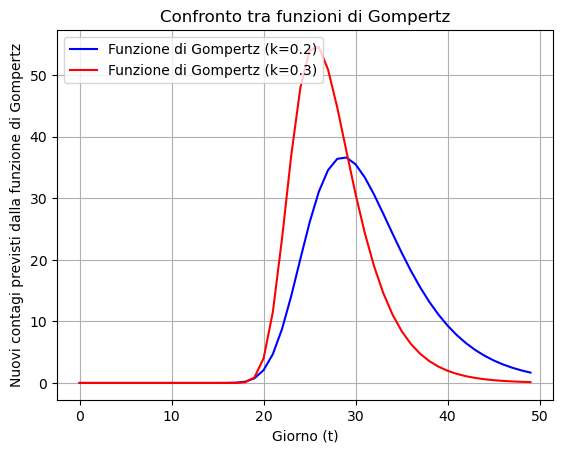

In [27]:
#Ripetiamo lo stesso procedimento con gli stessi parametri ma con la funzione di Gompertz


# Calcola i nuovi contagi per entrambe le funzioni di gompertz
gompertz_t_1 = [nuovi_contagi_gompertz(t, A, k1, t0) for t in valori_t]
gompertz_t_2 = [nuovi_contagi_gompertz(t, A, k2, t0) for t in valori_t]

# Plottiamo entrambe le funzioni
plt.plot(valori_t, gompertz_t_1, label="Funzione di Gompertz (k=0.2)", color="blue")
plt.plot(valori_t, gompertz_t_2, label="Funzione di Gompertz (k=0.3)", color="red")

plt.xlabel('Giorno (t)')
plt.ylabel('Nuovi contagi previsti dalla funzione di Gompertz')
plt.title('Confronto tra funzioni di Gompertz')
plt.grid(True)
plt.legend()
plt.show()

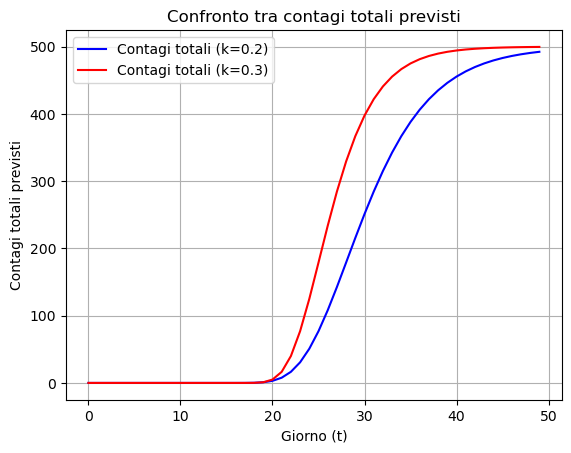

In [28]:
# Calcola i contagiati totali
contagi_totali_1 = np.cumsum(gompertz_t_1)
contagi_totali_2 = np.cumsum(gompertz_t_2)

# Plottiamo i contagiati totali
plt.plot(valori_t, contagi_totali_1, label="Contagi totali (k=0.2)", color="blue")
plt.plot(valori_t, contagi_totali_2, label="Contagi totali (k=0.3)", color="red")
plt.xlabel('Giorno (t)')
plt.ylabel('Contagi totali previsti')
plt.title('Confronto tra contagi totali previsti')
plt.grid(True)
plt.legend()
plt.show()

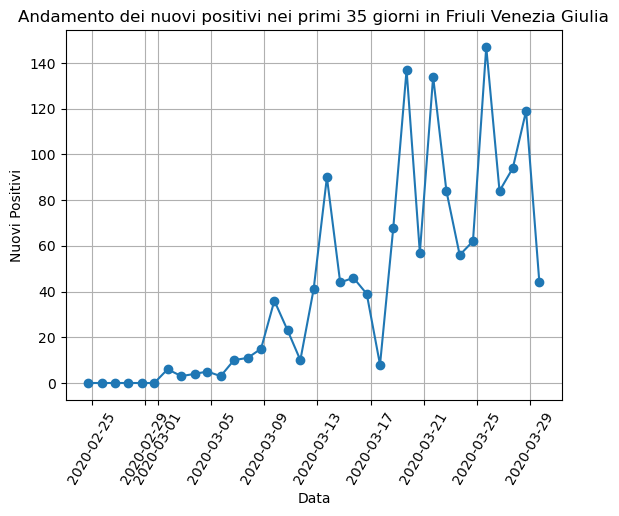

In [34]:
#PARTE 3
'''Iniziamo a studiare l andamento dei primi 35 giorni di contagio'''
# Limitiamo l'insieme dei dati ai primi 35 giorni
df_fvg_35 = df_fvg.head(35)

# E plottiamoli
plt.plot(df_fvg_35['data'], df_fvg_35['nuovi_positivi'], marker='o')
plt.xlabel('Data')
plt.ylabel('Nuovi Positivi')
plt.title('Andamento dei nuovi positivi nei primi 35 giorni in Friuli Venezia Giulia')
plt.xticks(rotation=60)
plt.grid(True)
plt.show()

C:\Users\Matteo\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Matteo\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 111.96it/s]


[1.91442186e+03 2.08054898e-01 2.90053359e+01]
[[-6.68984617e+01 -8.09532588e-03 -3.80891554e-01]
 [ 7.34959072e+01  7.15184818e-03  4.09597127e-01]]


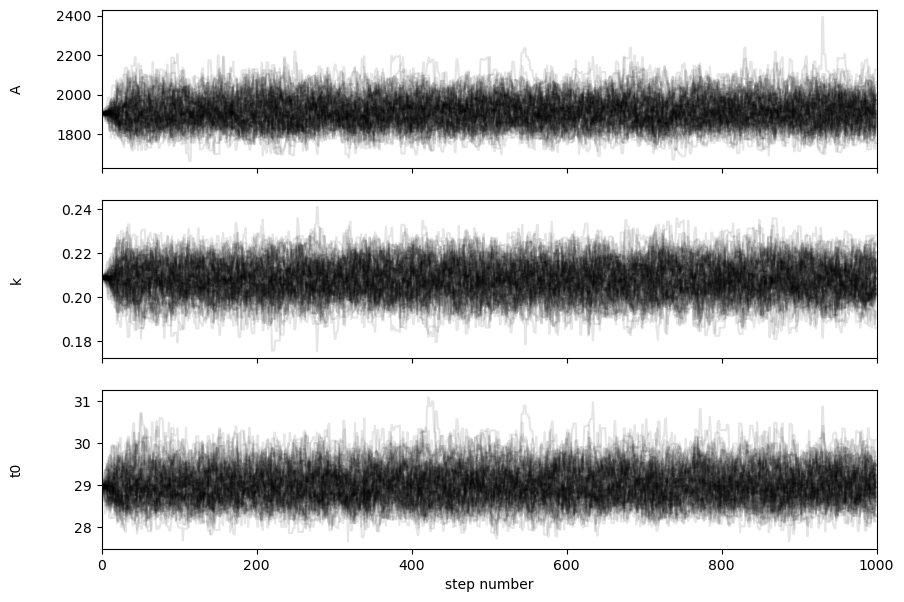

In [42]:
# Come prima, osserviamo i primi 35 giorni
t = np.arange(0, 35, 1)  # con 35 giorni
Nosservati = df_fvg.head(35)['nuovi_positivi'].to_numpy()

# Definiamo la funzione di log-likelihood della distribuzione di Poisson rispetto alla funzione logistica
def log_likelihood(params, t, osservati):
    A, k, t0 = params
    predetti = np.array([nuovi_contagi_logistica(i, A, k, t0) for i in t])
    log_likelihood = np.sum((-predetti) + osservati * np.log(predetti) - np.log(gamma(osservati.astype(int) + 1)))
    return log_likelihood



# la funzione log-prior, definendo anche i casi limite
def log_prior(params):
    A, k, t0 = params
    if 0 < A < 5000 and 0 < k < 10 and 0 < t0 < 35:
        return 0
    return -np.inf

# la funzione log-posterior, definendo anche i casi limite
def log_posterior(params, t, osservati):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, t, osservati)


# Definiamo grazie a lambda la funzione da minimizzare
NegLL = lambda *args: -log_posterior(*args)

# Parametri Di Partenza

A_0 = np.sum(Nosservati)
k_0 = 1.6
t0_0 = 20
parametri_0 = [A_0, k_0, t0_0]


# Ottimizziamo col modulo scy.py la funzione da minimizzare
result = minimize(NegLL, parametri_0, args=(t, Nosservati))

# Extract estimated parameters
A_1, k_1, t0_1 = result.x

# Scegliamo gli walker
ndim = 3
nwalkers = 100
pos = result.x * (1 + 1e-3 * np.random.randn(nwalkers, ndim))

# Avviamo l'algoritmo
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(t, Nosservati))
sampler.run_mcmc(pos, 1000, progress=True)

# Creazione del grafico
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["A", "k", "t0"]

# Plot Markov chains for each parameter
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

# Calculate estimated parameter values and uncertainties
Stima_L = np.mean(samples, axis=(0, 1))
Errore_L = np.percentile(samples, [16, 84], axis=(0, 1)) - Lestimated_params

print(Stima_L)
print(Errore_L)

C:\Users\Matteo\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.47it/s]


[3.22527307e+03 7.76637410e-02 4.70421791e+00]
[[-2.57367797e+02 -4.30998365e-03 -6.51492094e-01]
 [ 2.61798360e+02  4.27669370e-03  6.47969478e-01]]


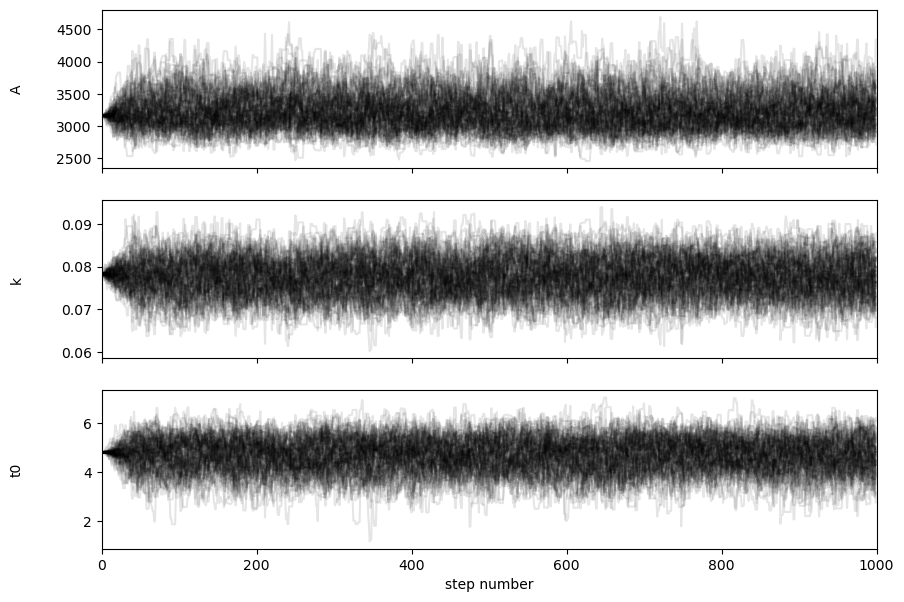

In [48]:
# Come prima, osserviamo i primi 35 giorni
t = np.arange(0, 35, 1)  # con 35 giorni
Nosservati = df_fvg.head(35)['nuovi_positivi'].to_numpy()

# Definiamo la funzione di log-likelihood della distribuzione di Poisson rispetto alla funzione logistica
def log_likelihood(params, t, osservati):
    A, k, t0 = params
    predetti = np.array([nuovi_contagi_gompertz(i, A, k, t0) for i in t])
    log_likelihood = np.sum((-predetti) + osservati * np.log(predetti) - np.log(gamma(osservati.astype(int) + 1)))
    return log_likelihood



# la funzione log-prior, definendo anche i casi limite
def log1_prior(params):
    A, k, t0 = params
    if 0 < A < 5000 and 0 < k < 10 and 0 < t0 < 35:
        return 0
    return -np.inf

# la funzione log-posterior, definendo anche i casi limite
def log_posterior(params, t, osservati):
    lp = log1_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, t, osservati)


# Definiamo grazie a lambda la funzione da minimizzare
NegLL = lambda *args: -log_posterior(*args)

# Parametri Di Partenza

A_0 = np.sum(Nosservati)
k_0 = 0.2
t0_0 = 20
parametri_0 = [A_0, k_0, t0_0]


# Ottimizziamo col modulo scy.py la funzione da minimizzare
result = minimize(NegLL, parametri_0, args=(t, Nosservati))

# Extract estimated parameters
A_1, k_1, t0_1 = result.x

# Scegliamo gli walker
ndim = 3
nwalkers = 100
pos = result.x * (1 + 1e-3 * np.random.randn(nwalkers, ndim))

# Avviamo l'algoritmo
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(t, Nosservati))
sampler.run_mcmc(pos, 1000, progress=True)

# Creazione del grafico
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["A", "k", "t0"]

# Plot Markov chains for each parameter
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

# Calculate estimated parameter values and uncertainties
Stima_G = np.mean(samples, axis=(0, 1))
Errore_G = np.percentile(samples, [16, 84], axis=(0, 1)) - Stima_G

print(Stima_G)
print(Errore_G)

Parametri funzione Logistica:
A = 1914.4218600689856
k = 0.20805489825949702
t0 = 29.005335942730316

Parametri funzione di Gompertz:
A = 3225.2730699298527
k = 0.07766374099070271
t0 = 4.7042179064679095


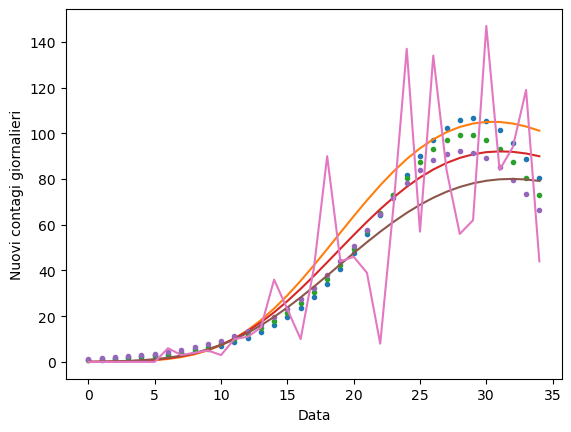

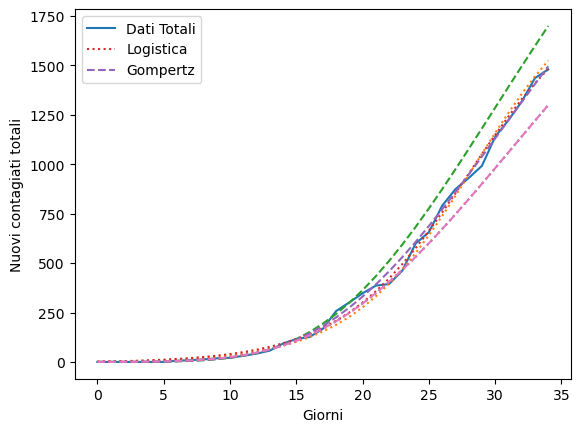

In [71]:
t = np.arange(0, 35,1)  # con 35 giorni
Nosservati = df_fvg.head(35)['nuovi_positivi'].to_numpy()
NosservatiTOT = np.cumsum(Nosservati)

# Parametri stimati + una deviazione standard
NLP = Stima_L[0] + Errore_L[1, 0]
KLP = Stima_L[1] + Errore_L[1, 1]
TLP = Stima_L[2] + Errore_L[1, 2]

NGP = Stima_G[0] + Errore_G[1, 0]
KGP = Stima_G[1] + Errore_G[1, 1]
TGP = Stima_G[2] + Errore_G[1, 2]

YLP = nuovi_contagi_logistica(t, NLP, KLP, TLP)
YGP = nuovi_contagi_gompertz(t, NGP, KGP, TGP)

plt.plot(t, (YLP), '.')
plt.plot(t, (YGP), '-')


# Parametri stimati

NL=Stima_L[0]
KL=Stima_L[1]
TL=Stima_L[2]

NG=Stima_G[0]
KG=Stima_G[1]
TG=Stima_G[2]

YL=nuovi_contagi_logistica(t, NL, KL, TL)
YG=nuovi_contagi_gompertz(t, NG, KG, TG)

plt.plot(t, (YL), '.')
plt.plot(t, (YG), '-')





#Parametri stimati - una deviazione standard

NLM=Stima_L[0]+Errore_L[0,0]
KLM=Stima_L[1]+Errore_L[0,1]
TLM=Stima_L[2]+Errore_L[0,2]

NGM=Stima_G[0]+Errore_G[0,0]
KGM=Stima_G[1]+Errore_G[0,1]
TGM=Stima_G[2]+Errore_G[0,2]

YLM=nuovi_contagi_logistica(t, NLM, KLM, TLM)
YGM=nuovi_contagi_gompertz(t, NGM, KGM, TGM)

plt.plot(t, (GLy), '.')
plt.plot(t, (GGy), '-')


#Mostriamo i parametri

print("Parametri funzione Logistica:")
print("A =", NL)
print("k =", KL)
print("t0 =", TL)

print("\nParametri funzione di Gompertz:")
print("A =", NG)
print("k =", KG)
print("t0 =", TG)




#Qui plottiamo il grafico
plt.plot(t, Nosservati)
plt.xlabel("Data")
plt.ylabel("Nuovi contagi giornalieri")
plt.show()


YLPTOT = np.cumsum(YLP[:35])
YGPTOT = np.cumsum(YGP[:35])
YLTOT = np.cumsum(YL[:35])
YGTOT = np.cumsum(YG[:35])
YGMTOT = np.cumsum(YGM[:35])
YGMTOT = np.cumsum(YGM[:35])

# Plot dei dati e delle funzioni
plt.plot(t, NosservatiTOT, label="Dati Totali")

# SOPRA
plt.plot(t, YLPTOT, linestyle="dotted")
plt.plot(t, YGPTOT, linestyle="--")

# CENTRO
plt.plot(t, YLTOT, label="Logistica", linestyle="dotted")
plt.plot(t, YGTOT, label="Gompertz", linestyle="--")

# SOTTO
plt.plot(t, YGMTOT, linestyle="dotted")
plt.plot(t, YGMTOT, linestyle="--")

plt.xlabel("Giorni")
plt.ylabel("Nuovi contagiati totali")
plt.legend()
plt.show()

Parametri funzione Logistica:
A = 1914.4218600689856
k = 0.20805489825949702
t0 = 29.005335942730316

Parametri funzione di Gompertz:
A = 3225.2730699298527
k = 0.07766374099070271
t0 = 4.7042179064679095


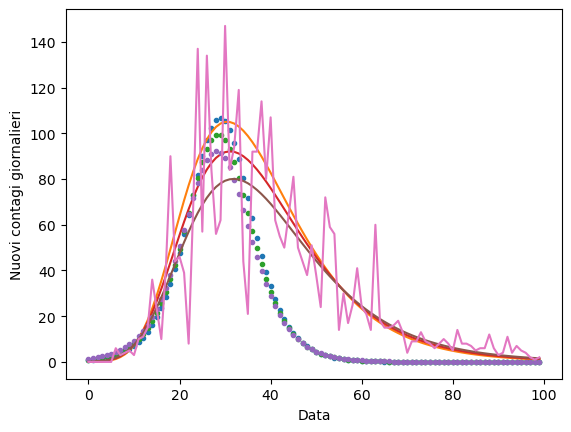

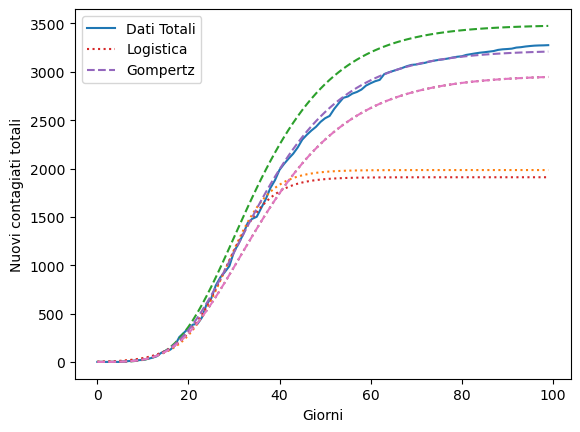

In [72]:
t = np.arange(0, 100,1)  # con 100 giorni
Nosservati = df_fvg.head(100)['nuovi_positivi'].to_numpy()
NosservatiTOT = np.cumsum(Nosservati)

# Parametri stimati + una deviazione standard
NLP = Stima_L[0] + Errore_L[1, 0]
KLP = Stima_L[1] + Errore_L[1, 1]
TLP = Stima_L[2] + Errore_L[1, 2]

NGP = Stima_G[0] + Errore_G[1, 0]
KGP = Stima_G[1] + Errore_G[1, 1]
TGP = Stima_G[2] + Errore_G[1, 2]

YLP = nuovi_contagi_logistica(t, NLP, KLP, TLP)
YGP = nuovi_contagi_gompertz(t, NGP, KGP, TGP)

plt.plot(t, (YLP), '.')
plt.plot(t, (YGP), '-')


# Parametri stimati

NL=Stima_L[0]
KL=Stima_L[1]
TL=Stima_L[2]

NG=Stima_G[0]
KG=Stima_G[1]
TG=Stima_G[2]

YL=nuovi_contagi_logistica(t, NL, KL, TL)
YG=nuovi_contagi_gompertz(t, NG, KG, TG)

plt.plot(t, (YL), '.')
plt.plot(t, (YG), '-')





#Parametri stimati - una deviazione standard

NLM=Stima_L[0]+Errore_L[0,0]
KLM=Stima_L[1]+Errore_L[0,1]
TLM=Stima_L[2]+Errore_L[0,2]

NGM=Stima_G[0]+Errore_G[0,0]
KGM=Stima_G[1]+Errore_G[0,1]
TGM=Stima_G[2]+Errore_G[0,2]

YLM=nuovi_contagi_logistica(t, NLM, KLM, TLM)
YGM=nuovi_contagi_gompertz(t, NGM, KGM, TGM)

plt.plot(t, (YLM), '.')
plt.plot(t, (YGM), '-')


#Mostriamo i parametri

print("Parametri funzione Logistica:")
print("A =", NL)
print("k =", KL)
print("t0 =", TL)

print("\nParametri funzione di Gompertz:")
print("A =", NG)
print("k =", KG)
print("t0 =", TG)




#Qui plottiamo il grafico
plt.plot(t, Nosservati)
plt.xlabel("Data")
plt.ylabel("Nuovi contagi giornalieri")
plt.show()


YLPTOT = np.cumsum(YLP[:100])
YGPTOT = np.cumsum(YGP[:100])
YLTOT = np.cumsum(YL[:100])
YGTOT = np.cumsum(YG[:100])
YGMTOT = np.cumsum(YGM[:100])
YGMTOT = np.cumsum(YGM[:100])

# Plot dei dati e delle funzioni
plt.plot(t, NosservatiTOT, label="Dati Totali")

# SOPRA
plt.plot(t, YLPTOT, linestyle="dotted")
plt.plot(t, YGPTOT, linestyle="--")

# CENTRO
plt.plot(t, YLTOT, label="Logistica", linestyle="dotted")
plt.plot(t, YGTOT, label="Gompertz", linestyle="--")

# SOTTO
plt.plot(t, YGMTOT, linestyle="dotted")
plt.plot(t, YGMTOT, linestyle="--")

plt.xlabel("Giorni")
plt.ylabel("Nuovi contagiati totali")
plt.legend()
plt.show()

                    data  nuovi_positivi
0    2020-09-03 17:00:00              25
1    2020-09-04 17:00:00              23
2    2020-09-05 17:00:00              49
3    2020-09-06 17:00:00              20
4    2020-09-07 17:00:00              11
...                  ...             ...
1269 2024-02-24 17:00:00               4
1270 2024-02-25 17:00:00               1
1271 2024-02-26 17:00:00               4
1272 2024-02-27 17:00:00               3
1273 2024-02-28 17:00:00               5

[1274 rows x 2 columns]


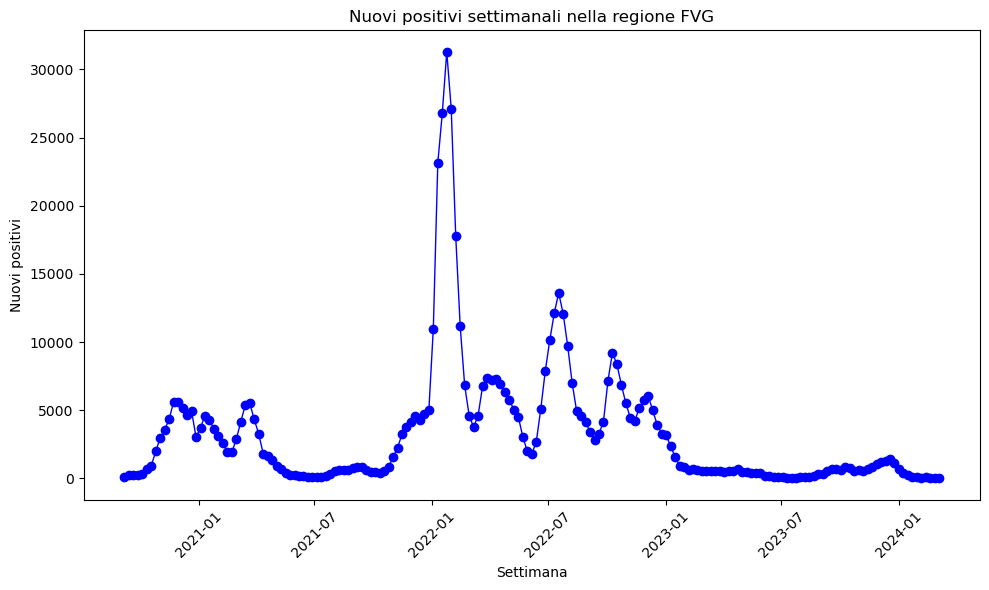

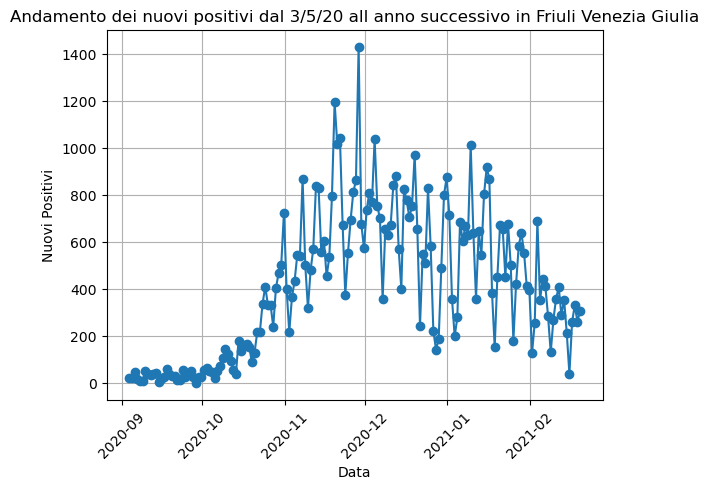

In [75]:
# Leggi il file CSV
df = pd.read_csv(r'C:\Users\Matteo\Desktop\Dati1.csv')

# Filtra i dati solo per la regione FVG
df_fvg = df[df['denominazione_regione'] == 'Friuli Venezia Giulia']

# Ordina i dati per data
df_fvg = df_fvg.sort_values(by='data')

# Seleziona solo le colonne di interesse
df_fvg = df_fvg[['data', 'nuovi_positivi']]

# Definisci la data di inizio analisi
start_date = '2020-09-03'

# Filtra i dati a partire dalla data di interesse
df_fvg = df_fvg[df_fvg['data'] >= start_date]

# Reset dell'indice
df_fvg = df_fvg.reset_index(drop=True)

# Converti la colonna 'data' in formato datetime
df_fvg['data'] = pd.to_datetime(df_fvg['data'])

# Stampa il DataFrame risultante
print(df_fvg)

# Raggruppa i dati per settimana e calcola la somma dei nuovi positivi
df_weekly = df_fvg.resample('W-Mon', on='data').sum()

# Plot a linee e punti per dati settimanali
plt.figure(figsize=(10, 6))
plt.plot(df_weekly.index, df_weekly['nuovi_positivi'], marker='o', linestyle='-', color='blue', linewidth=1)
plt.title('Nuovi positivi settimanali nella regione FVG')
plt.xlabel('Settimana')
plt.ylabel('Nuovi positivi')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Limita ai primi 170 giorni
df_fvg_365 = df_fvg.head(170)

# Plot dei dati
plt.plot(df_fvg_365['data'], df_fvg_365['nuovi_positivi'], marker='o')
plt.xlabel('Data')
plt.ylabel('Nuovi Positivi')
plt.title('Andamento dei nuovi positivi dal 3/5/20 all anno successivo in Friuli Venezia Giulia')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
